In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score

import winsound    
import matplotlib.pyplot as plt
from joblib import load
from joblib import dump


In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    # Set the GPU as the default device
    tf.config.experimental.set_memory_growth(gpus[0], True)

    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

  except RuntimeError as e:
    print(e)

print('Memory:' ,tf.config.experimental.get_memory_info('GPU:0')['current'])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory: 0


In [3]:
#Size of our input images
SIZE = 128

#############################################################################
#Define generators for training, validation and also anomaly data.

batch_size = 64
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'DATA/normal',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    'DATA/val_images',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    'DATA/defects',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

Found 1066 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 1737 images belonging to 2 classes.


# MODEL

In [4]:
#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

### Train model 

In [5]:
history = model.fit(
        train_generator,
        epochs=1,
        validation_data=validation_generator,
        shuffle = True)
winsound.Beep(1500, 800)

17/17 [==============================] - 46s 2s/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0305 - val_mse: 0.0305


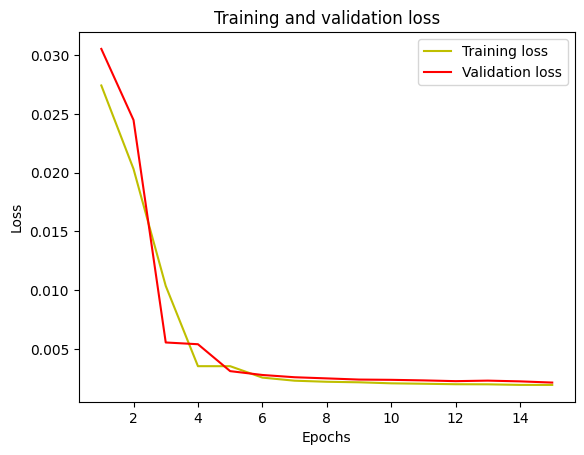

In [6]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
model.save('models/3_128')

INFO:tensorflow:Assets written to: models/3_128\assets


INFO:tensorflow:Assets written to: models/3_128\assets


In [8]:
validation_error = model.evaluate_generator(validation_generator)
anomaly_error = model.evaluate_generator(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

C:\Users\ataka\AppData\Local\Temp\ipykernel_10344\106648825.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_error = model.evaluate_generator(validation_generator)
C:\Users\ataka\AppData\Local\Temp\ipykernel_10344\106648825.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  anomaly_error = model.evaluate_generator(anomaly_generator)


Recon. error for the validation (normal) data is:  [0.0017290028044953942, 0.0017290028044953942]
Recon. error for the anomaly data is:  [0.002377343364059925, 0.002377343364059925]


### Train second model and KDE

In [6]:
encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)      

In [7]:
from sklearn.neighbors import KernelDensity

encoded_images = encoder_model.predict_generator(train_generator)

encoder_output_shape = encoder_model.output_shape
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

C:\Users\ataka\AppData\Local\Temp\ipykernel_13776\2703699447.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_model.predict_generator(train_generator)


In [11]:
encoder_model.save('models/e3_128')

dump(kde,'models/kde3_128.pkl')

INFO:tensorflow:Assets written to: models/e3_128\assets


INFO:tensorflow:Assets written to: models/e3_128\assets


['models/kde3_128.pkl']

In [8]:
winsound.Beep(1600, 900)

# PREDICT

In [8]:
defect_path = 'DATA/test/defect'
normal_path = 'DATA/test/normal'

all_defect_path = 'DATA/defects/images'
size = 128


# Load dataset
def load_dataset(defect_path, normal_path, size=256):
    images_temp = []
    labels_temp = []
    for file in os.listdir(defect_path):
        img = Image.open(os.path.join(defect_path, file))
        img = img.resize((size, size))  
        img = np.array(img) / 255.0  
        images_temp.append(img)
        labels_temp.append(1)  

    for file in os.listdir(normal_path):
        img = Image.open(os.path.join(normal_path, file))
        img = img.resize((size, size))  
        img = np.array(img) / 255.0  
        images_temp.append(img)
        labels_temp.append(0) 

    return np.array(images_temp), np.array(labels_temp)

# Split dataset into training and testing sets
images, labels = load_dataset(defect_path, normal_path, size)

In [9]:
def calc_density_and_recon_error_no_mean(images):
    '''
    Эта функция принимает пакет изображений и вычисляет плотность и ошибку реконструкции
    для каждого изображения в пакете. Она возвращает средние значения и стандартные отклонения этих величин.
    '''
    density_list=[]
    recon_error_list=[]
    for im in range(0, len(images)):
        
        img  = images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    return density_list, recon_error_list

In [10]:
all_test = calc_density_and_recon_error_no_mean(images)
winsound.Beep(1600, 700)

1/1 [==============================] - 0s 41ms/step - loss: 0.0497 - mse: 0.0497


In [11]:
print(all_test[0])
print(all_test[1])

[2815.834149940286, 2814.21440027765, 2815.106448149729, 2815.308472278438, 2818.467326663182, 2817.268363930894, 2816.798474089546, 2816.1789404495503, 2811.866026212844, 2813.265918470514, 2801.484263705737, 2808.8240465763643, 2810.721877878792, 2807.855614065298, 2808.426613887192, 2814.8777702553425, 2807.908550296213, 2812.4135794228396, 2811.936405618088, 2811.115835073194, 2802.104112763593, 2800.022053630217, 2798.638434511157, 2778.8092914742556, 2770.6111797367394, 2793.69351218349, 2545.6233682701945, 2709.294992414796, 2716.3276697155816, 2694.2285938337513, 2725.7507005224575, 2672.09583198341, 2756.062601505772, 2741.205864650348, 2799.691808714966, 2785.5312906169597, 2789.977485677371, 2795.2619663774635, 2806.3188073701212, 2784.842562610225, 2791.872839809955, 2793.890267275374, 2754.9429122838, 2802.975308208172, 2811.5775749691547, 2813.2528936085987, 2811.3870566981195, 2814.44720437257, 2818.972108361151, 2790.8438122567686, 2767.221892577416, 2736.7260541438886,

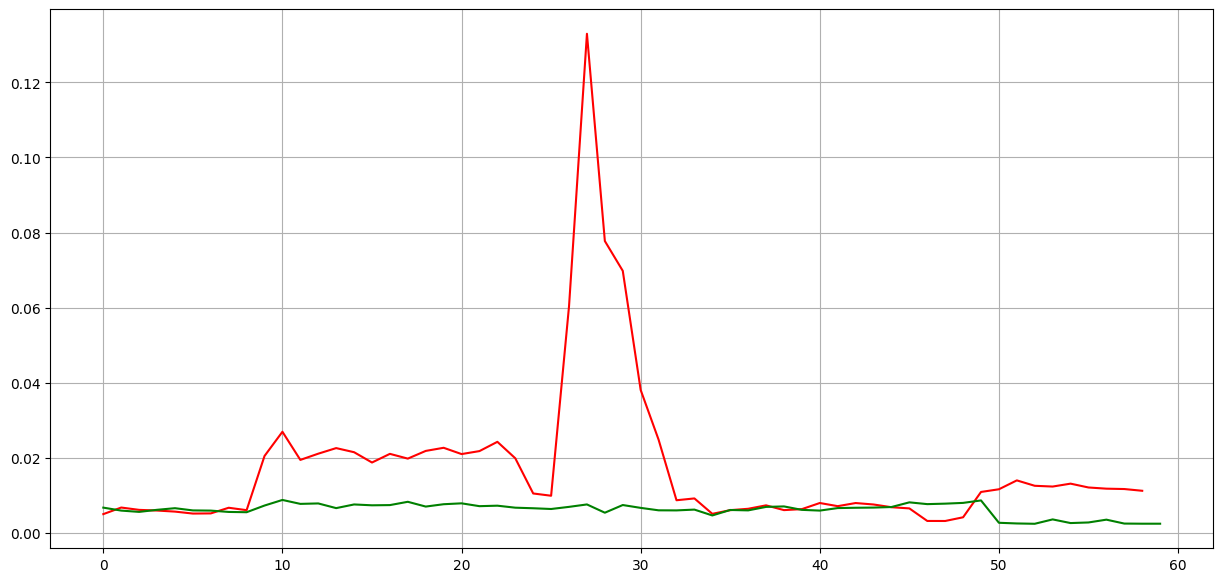

In [17]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(15, 7))

plt.plot(all_test[1][:59],c='r')
plt.plot(all_test[1][100:160],c='g')
plt.grid()


plt.show()

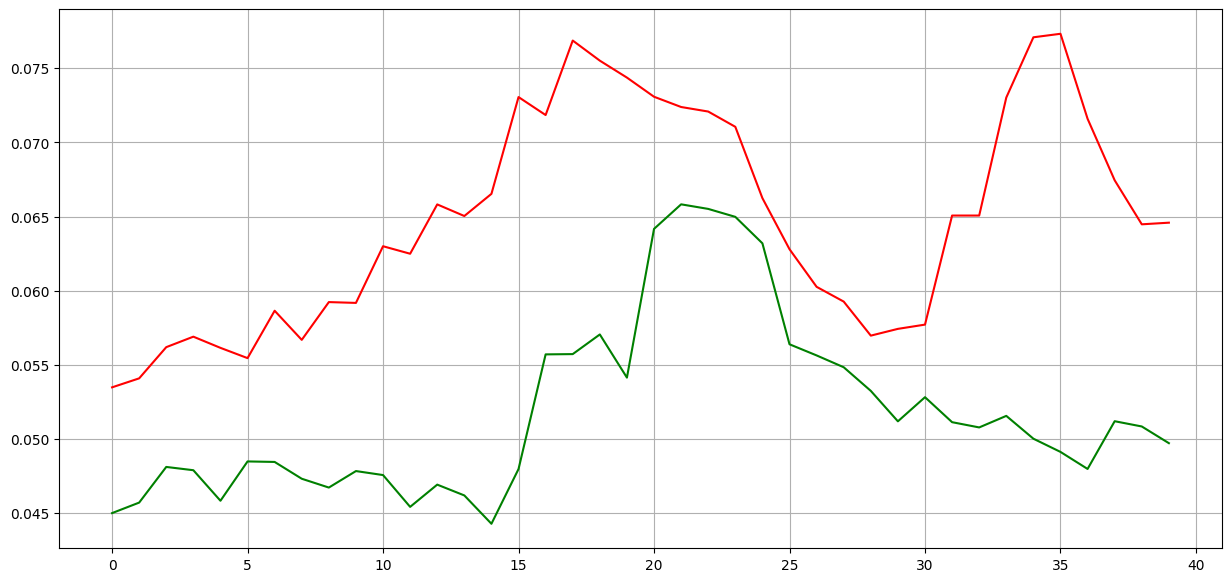

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(15, 7))

plt.plot(all_test[1][60:100],c='r')
plt.plot(all_test[1][160:],c='g')
plt.grid()


plt.show()

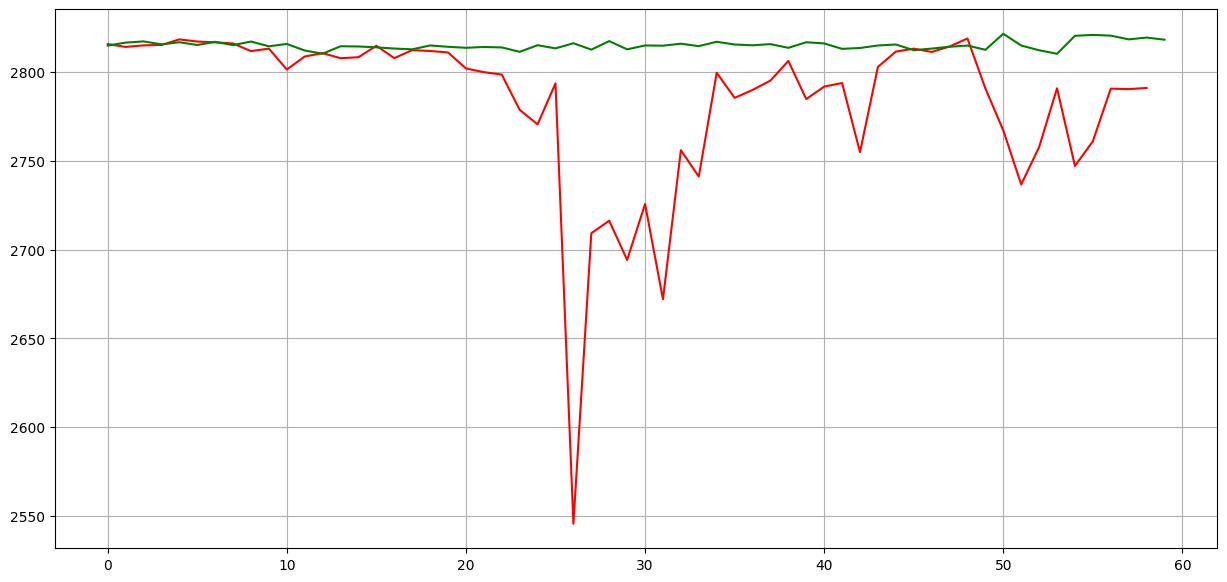

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(15, 7))

plt.plot(all_test[0][:59],c='r')
plt.plot(all_test[0][100:160],c='g')
plt.grid()


plt.show()

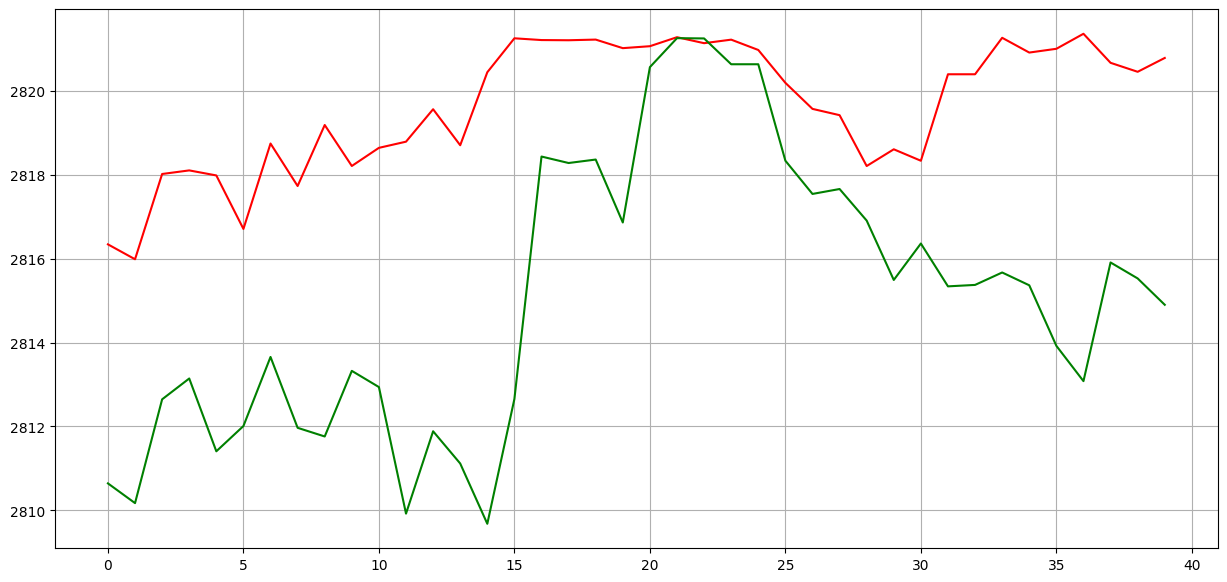

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(15, 7))

plt.plot(all_test[0][60:100],c='r')
plt.plot(all_test[0][160:],c='g')
plt.grid()


plt.show()

In [18]:
import random
def check_anomaly(imgs, density_threshold=2821.25, reconstruction_error_threshold=0.006):
    pred_labels = []

    for i in range(len(imgs)):
        img = imgs[i][np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) 
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
        density = kde.score_samples(encoded_img)[0] 

        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

        if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
            pred_labels.append(1)
            
        else:
            pred_labels.append(0)

        
    return pred_labels

In [19]:
pred_labels = check_anomaly(images)

1/1 [==============================] - 0s 71ms/step - loss: 0.0040 - mse: 0.0040


In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import f1_score, recall_score, precision_score

accuracy = accuracy_score(labels, pred_labels)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(labels, pred_labels)
print("F1 Score:", f1)

# Calculate Recall
recall = recall_score(labels, pred_labels)
print("Recall:", recall)

# Calculate Precision
precision = precision_score(labels, pred_labels)
print("Precision:", precision)


report = classification_report(labels, pred_labels)
print("Classification Report:\n", report)

conf_mat = confusion_matrix(labels, pred_labels)
print("Confusion Matrix:\n", conf_mat)

Accuracy: 0.485
F1 Score: 0.5422222222222223
Recall: 0.61
Precision: 0.488
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.36      0.41       100
           1       0.49      0.61      0.54       100

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.48      0.48      0.48       200

Confusion Matrix:
 [[36 64]
 [39 61]]
